In [1]:
#Imports and working directory
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt

import os 
os.chdir(r'C:\Users\david\Desktop\TFG\Implementación\Model\Data')

#Open a console
%qtconsole

Load the data.

adults_first_admission_v2.csv -Contains patient information and class

SeverityScore_20200611.csv -Contains the features for the calculation of the Severity Score.

The link between both dataframes is 'icustay_id'

In [2]:
#Load the data

#patient info
adults = pd.read_csv('adults_first_admission_v2_20200611.csv')

#severity scores
sofa = pd.read_csv('sofa_20200611.csv')
oasis = pd.read_csv('oasis_20200611.csv')
saps = pd.read_csv('saps_20200611.csv')
sapsii = pd.read_csv('sapsii_20200611.csv')

#dictionary with the severity scores dataframes
severity = {'sofa':sofa, 'oasis':oasis, 'saps':saps, 'sapsii':sapsii}

Drop the columns that contain the feature scores (ie. heart rate score), the severity score (ie. sofa) and patient information except from 'icustay_id' in order to leave each dataframe with just the features used to calculate the severity score plus the id 'icustay_id'.

In [19]:
patient_info_cols = ['subject_id', 'hadm_id'] 
oasis_info_cols = ['icustay_age_group', 'hospital_expire_flag', 'icustay_expire_flag']
sofa_scores = ['coagulation', 'respiration', 'liver', 'renal', 'cardiovascular', 'cns']

for key in severity:
    severity[key].drop(severity[key].filter(regex = '_score').columns, axis = 1, inplace = True)
    severity[key].drop(severity[key].filter(regex = key).columns, axis = 1, inplace = True)
    if key == 'sofa':
        severity[key].drop(sofa_scores, axis = 1, inplace = True)
    severity[key].drop(patient_info_cols, axis = 1, inplace = True)
    if key == 'oasis':
        severity[key].drop(oasis_info_cols, axis = 1, inplace = True)

Now we want to get which columns have na values for each dataframe to decide how we will solve this missing values problems depending on the feature nature.

In [20]:
for key in severity:
    print('---')
    print(key)
    print('---')
    print(severity[key].isnull().sum())  


---
sofa
---
icustay_id            0
pao2fio2          20341
platelet            736
bilirubin         22271
dopamine          36872
epinephrine       37362
norepinephrine    34870
dobutamine        38232
map                 737
gcs                 843
creatinine          623
uo                 1799
dtype: int64
---
oasis
---
icustay_id            0
age                   0
preiculos             0
gcs                 843
heartrate_min       733
heartrate_max       733
meanbp_min          737
meanbp_max          737
resprate_min        787
resprate_max        787
tempc_min          1483
tempc_max          1483
uo                 1799
mechvent              0
electivesurgery       0
dtype: int64
---
saps
---
icustay_id             0
age                    0
heartrate_min        733
heartrate_max        733
sysbp_min            763
sysbp_max            763
resprate_min         787
resprate_max         787
tempc_min           1483
tempc_max           1483
uo                  1799
mechvent   

Now we will look at the distribution for some of the features (excluding the missing values).

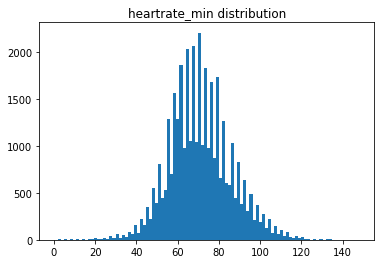

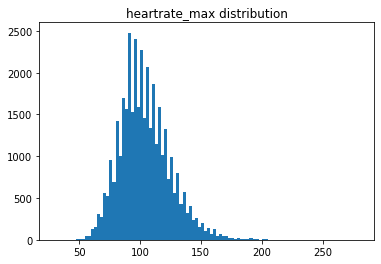

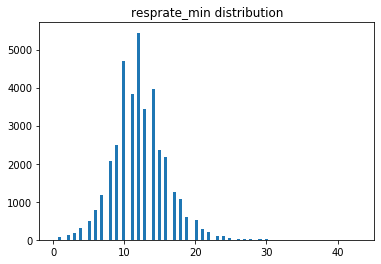

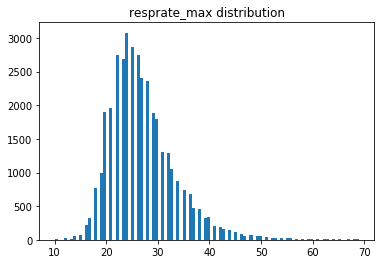

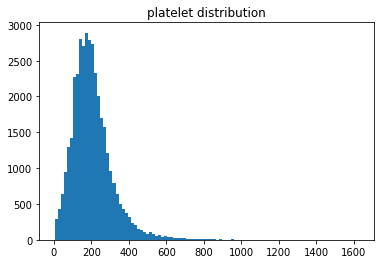

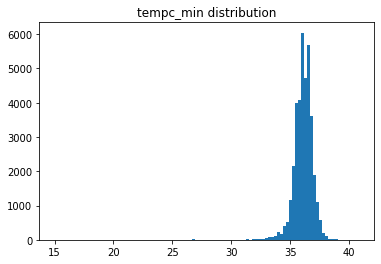

In [30]:
cols = ['heartrate_min', 'heartrate_max', 'resprate_min', 'resprate_max', 'platelet', 'tempc_min']

for c in cols:
    for key in severity:
        if c in severity[key].columns:
            plt.hist(severity[key][c][~np.isnan(severity[key][c])], bins = 100)
            plt.title(c + ' distribution')
            plt.savefig('feature_distribution/' + c + '.png')
            plt.show()
            break
    pass

We will fill the missing values with 0 in the following cases
    1. Flag features: where we know that values are [0,1] and nan means 0.
    2. Substance administration features: this are features that contain the quantity of an administrated substance to a patient, if no substance was administrated, the feature contains nan which means 0.

The rest of the features with missing values correspond to either laboratory events or charted events and will be filled with the gaussian distribution of the non-missing values.

We observe that for pao2fio2 and bilirubin features the missing values are too many.
For pao2fio2 that means ...
For bilirubin that means most of the patients don't take the bilirubin test.
    So we will test the performance of the model by filling the missing values with 0 and by directly removing the feature.
    For the first try we will fill the missing values with 0.

In [5]:
flag_features_saps = ['cpap']
flag_features_sapsii = ['aids', 'hem', 'mets']
substance_features_sofa = ['dopamine', 'epinephrine', 'norepinephrine', 'dobutamine']

too_many_missing_sofa = ['pao2fio2', 'bilirubin']
too_many_missing_sapsii = ['pao2fio2', 'bilirubin_min', 'bilirubin_max']

In [6]:
for key in severity:
    if key == 'sofa':
        severity[key][substance_features_sofa].fillna(0, inplace = True)
        severity[key][too_many_missing_sofa].fillna(0, inplace = True)
    if key == 'saps':
        severity[key][flag_features_saps].fillna(0, inplace = True)
    if key == 'sapsii':
        severity[key][flag_features_sapsii].fillna(0, inplace = True)
        severity[key][too_many_missing_sapsii].fillna(0, inplace = True)
    #for the columns left with missing values, replace them with the gaussian distribution of the column
    cols = severity[key].columns[severity[key].isna().any()].tolist()
    for col in cols:
        mu, sigma = severity[key][col].mean(), severity[key][col].std()
        severity[key][col].fillna(np.random.normal(mu, sigma), inplace = True)  
    
    

C:\Users\david\Anaconda3\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [7]:
#Check there are no missing values anymore
for key in severity:
    print('---')
    print(key)
    print('---')
    print(severity[key].isnull().sum())

---
sofa
---
icustay_id        0
pao2fio2          0
platelet          0
bilirubin         0
dopamine          0
epinephrine       0
norepinephrine    0
dobutamine        0
map               0
gcs               0
creatinine        0
uo                0
dtype: int64
---
oasis
---
icustay_id         0
age                0
preiculos          0
gcs                0
heartrate_min      0
heartrate_max      0
meanbp_min         0
meanbp_max         0
resprate_min       0
resprate_max       0
tempc_min          0
tempc_max          0
uo                 0
mechvent           0
electivesurgery    0
dtype: int64
---
saps
---
icustay_id         0
age                0
heartrate_min      0
heartrate_max      0
sysbp_min          0
sysbp_max          0
resprate_min       0
resprate_max       0
tempc_min          0
tempc_max          0
uo                 0
mechvent           0
cpap               0
bun_min            0
bun_max            0
hematocrit_min     0
hematocrit_max     0
wbc_min            0
w

After filling the missing values we will perform Z-Score Normalization and One-Hot Encoding for numerical and categorical features respectively.

The only categorical feature is 'admissiontype' from the sapsii dataframe.

We can define the numerical features as the features where the list of unique values has more than 2 elements. In case of the flag features, which are not numerical features, the list of unique values is [0,1] so by taking list with length greater than 2 we are avoiding to incorrectly transform the flag features.

We also need to transform the column 'preiculos' from the oasis dataframe which have a format like 'X days hh:mm:ss' in string type. We will take into account just the days of pre-icu length of stay.

In [8]:
severity['sapsii'] = pd.get_dummies(data=severity['sapsii'], columns=['admissiontype'])

severity['oasis']['preiculos'].loc[~severity['oasis']['preiculos'].str.contains('days')] = '0'
splitted = severity['oasis']['preiculos'].str.split('days', expand = True) 
severity['oasis']['preiculos'] = splitted[0].astype(int)

def sigmoid(x):
    y = 1/(1 + np.exp(-x))
    return y

for key in severity:
    cols = [x for x in severity[key].columns if x != 'icustay_id' and len(severity[key][x].unique()) > 2]
    Zscore
    #severity[key][cols] = severity[key][cols].apply(zscore)
    
    #Min-Max Scaling
    #severity[key][cols] = minmax_scale(severity[key][cols])
    
    #Sigmoid
    #severity[key][cols] = severity[key][cols].apply(sigmoid)

C:\Users\david\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Before we can start with the deep learning model implementation, we have to merge the feature dataframes with the 'adults' dataframe to get the class of each patient, having icustay_id as the index.

In [9]:
for key in severity:
    severity[key] = pd.merge(severity[key], adults[['icustay_id', 'clase']], on = 'icustay_id')
    severity[key].set_index('icustay_id', inplace = True)

Save each dataframe in csv.



In [10]:
for key in severity:
    severity[key].to_csv(key+'_processed.csv', index = True)